In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Hyperparameters
batch_size = 128
z_dim = 100
epochs = 50
lr = 0.0002
num_classes = 10
img_size = 28

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Generator and Discriminator
# -------------------------------

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.net = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()  # Output image pixels in [-1, 1]
        )

    def forward(self, z, labels):
        c = self.label_embed(labels)
        x = torch.cat([z, c], dim=1)
        return self.net(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.net = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), -1)
        c = self.label_embed(labels)
        x = torch.cat([x, c], dim=1)
        return self.net(x)

# -------------------------------
# Training Loop
# -------------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        bs = imgs.size(0)

        # Train Discriminator
        z = torch.randn(bs, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (bs,), device=device)
        fake_imgs = G(z, gen_labels)

        real_validity = D(imgs, labels)
        fake_validity = D(fake_imgs.detach(), gen_labels)

        real_loss = criterion(real_validity, torch.ones_like(real_validity))
        fake_loss = criterion(fake_validity, torch.zeros_like(fake_validity))
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(bs, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (bs,), device=device)
        gen_imgs = G(z, gen_labels)
        validity = D(gen_imgs, gen_labels)

        g_loss = criterion(validity, torch.ones_like(validity))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(G.state_dict(), f"generator_epoch_{epoch+1}.pth")

# Final save
torch.save(G.state_dict(), "generator_final.pth")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.12MB/s]


Epoch 1/50 | D Loss: 0.2057 | G Loss: 5.7379
Epoch 2/50 | D Loss: 0.1656 | G Loss: 4.8801
Epoch 3/50 | D Loss: 0.6572 | G Loss: 2.4416
Epoch 4/50 | D Loss: 0.4690 | G Loss: 3.4951
Epoch 5/50 | D Loss: 0.1731 | G Loss: 2.7745
Epoch 6/50 | D Loss: 0.1341 | G Loss: 3.5746
Epoch 7/50 | D Loss: 0.2878 | G Loss: 6.3106
Epoch 8/50 | D Loss: 0.3078 | G Loss: 4.2122
Epoch 9/50 | D Loss: 0.0434 | G Loss: 5.6981
Epoch 10/50 | D Loss: 0.2838 | G Loss: 5.0186
Epoch 11/50 | D Loss: 0.1568 | G Loss: 4.1108
Epoch 12/50 | D Loss: 0.4336 | G Loss: 3.8530
Epoch 13/50 | D Loss: 0.1886 | G Loss: 4.0529
Epoch 14/50 | D Loss: 0.3604 | G Loss: 3.0726
Epoch 15/50 | D Loss: 0.5611 | G Loss: 6.2879
Epoch 16/50 | D Loss: 0.2811 | G Loss: 5.8289
Epoch 17/50 | D Loss: 0.2351 | G Loss: 4.5816
Epoch 18/50 | D Loss: 0.1453 | G Loss: 5.7274
Epoch 19/50 | D Loss: 0.1960 | G Loss: 5.3511
Epoch 20/50 | D Loss: 0.2569 | G Loss: 2.0045
Epoch 21/50 | D Loss: 0.2357 | G Loss: 4.6531
Epoch 22/50 | D Loss: 0.1064 | G Loss: 5.18

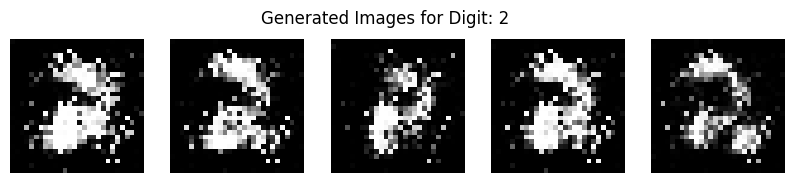

In [3]:
import torch
import matplotlib.pyplot as plt

# Ensure Generator class matches training
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(10, 10)
        self.net = nn.Sequential(
            nn.Linear(110, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_embed(labels)
        x = torch.cat([z, c], dim=1)
        return self.net(x).view(-1, 1, 28, 28)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
G.load_state_dict(torch.load("generator_final.pth", map_location=device))
G.eval()

# Generate 5 images of a chosen digit (e.g., 3)
digit = 2
z = torch.randn(5, 100).to(device)
labels = torch.tensor([digit] * 5, dtype=torch.long).to(device)

with torch.no_grad():
    gen_images = G(z, labels).cpu()

# Plot the images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(gen_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle(f"Generated Images for Digit: {digit}")
plt.show()